In [1]:
import os ##冰激淋+擔擔麵+蜂蜜檸檬適用

os.environ["CUDA_VISIBLE_DEVICES"] = "1" #使用第0張顯卡 ##冰激淋+擔擔麵+蜂蜜檸檬適用 0or1

In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
set_session(tf.Session(config=config))

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import keras
from keras import regularizers
from keras import backend as K
from keras.layers import Input, LSTM, Dense, Dropout, Flatten, Convolution1D, MaxPooling1D, Activation, BatchNormalization,\
Lambda, Concatenate, Add, Conv2D, Conv1D,TimeDistributed,MaxPooling2D
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU
from keras.models import Model
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from itertools import permutations
import matplotlib.pyplot as plt
import psutil
import os
import numpy as np
import pandas as pd
import datetime
import warnings
import pickle
import csv
import random
from keras.models import Sequential
from keras import backend as K

In [4]:
"""
基本設定
"""
#n=148335 #用2016 1~3月的資料 288x(31+29+31+30+31+30+...)=52416 210528-1(all) 差值在減一  
l=36 #區間為12小時
currency = ["CHF","CAD","GBP","JPY","EUR","HKD"]
#SEK:瑞典克朗  CHF:瑞士法郎 CAD:加拿大幣 GBP:英鎊 
#currency = ["BTC","DASH","ETH","LTC","JBY","GBP","EUR","AUD","US"]
currencynum = len(currency)
month = [0,31,60,91,121,152,182,213,244,274,305,335,366,397,425,456,486,517,547,578,609,639,670,700,731] #2016是閏年 366天
daynum = [0,5802,11745,18351,24380,30579,36861,42795,49201,55342,61230,67400,73732,79984,85726,92343,98127,104692,111028,117076,123700,129807,136083,142401,148335]
question = ["trand","volatility"]
# 貨幣組合，1 : P, 0 : C
M=0
head = 9
tail = 21
epochs = 45
batch_size = 4096
pl=4
kn=5
all_cur_pair = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
if(M==0):
    all_cur_pair_P = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
elif(M==1):
    all_cur_pair_P = list(permutations(currency,2))# (Pn取2) 問題有先後順序時使用  
all_question= list(permutations(question,1))
np.set_printoptions(suppress=True)#不要用科學符號輸出
lastepoch_train_acc = []
lastepoch_test_acc = []
lastepoch_train_loss = []
lastepoch_test_loss = []
total_test_vol = []
total_test_trend = []
train_length=3 
test_length=1 

In [5]:
"""""""""
str, onehotcode, company code轉換
"""""""""
currencylist = {}
questionlist = {}
for i in range(len(currency)):
    currencylist[i] = currency[i]

for i in range(len(question)):
    questionlist[i] = question[i]

def str_to_currency(cur):
    return {v: k for k, v in currencylist.items()}[cur]

def str_to_question(q):
    return {v: k for k, v in questionlist.items()}[q]


def one_hot_currency(currencylist):
    d = {}
    temp = np.eye((len(currencylist)))
    for i in range(len(currencylist)):
        d[i] = temp[i]
    return d

def one_hot_question(questionlist):
    d = {}
    temp = np.eye((len(questionlist)))
    for i in range(len(questionlist)):
        d[i] = temp[i]
    return d

onehotcurrency = one_hot_currency(currencylist)
onehotquestion = one_hot_question(questionlist)


In [6]:

"""
Q&A
"""
vol='volatility'
def set_question(com1, com2,typeq):
    return np.concatenate((onehotquestion[str_to_question(typeq)],onehotcurrency[str_to_currency(com1)], onehotcurrency[str_to_currency(com2)]))

qtype = ['big']
HVqtype = ['big']

"""比漲幅程度類問題"""
def set_question_and_answer_pair(data, data2, n, all_cur_pair_P): #比較波動率大小的問題
    q_pair = {}
    a_pair = {}
    outcome=np.zeros((currencynum,1))
    for c in range(currencynum):
        data2[c]=data2[c]-data2[c][0]
    #data_sum=np.sum(data,axis=1)
    data2_sum=np.sum(data2,axis=1)
    outcome[0]=(data2_sum[0])
    outcome[1]=(data2_sum[1])
    outcome[2]=(data2_sum[2])
    outcome[3]=(data2_sum[3])
    outcome[4]=(data2_sum[4])
    outcome[5]=(data2_sum[5])

    tmp_q = []
    tmp_a = []
    for j in range(len(all_cur_pair_P)):
        tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1],all_question[0][0]))
    q_pair[i] = tmp_q        
    for j in range(len(all_cur_pair_P)):
        if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
            tmp_a.append(1)
        else:
            tmp_a.append(0)
    a_pair[i] = tmp_a
    return (data, q_pair, a_pair)


"""History Volatility類問題"""
def set_HVquestion_and_HVanswer_pair(data, data2,all_cur_pair_P): #比較波動率大小的問題
    q_HVpair = {}
    a_HVpair = {}
    outcome=np.zeros((currencynum,1))
    for c in range(currencynum):
        data2[c]=data2[c]-data2[c][0]
    data2_std=np.std(data2,axis=1) 
    outcome[0]=data2_std[0]
    outcome[1]=data2_std[1]
    outcome[2]=data2_std[2]
    outcome[3]=data2_std[3]
    outcome[4]=data2_std[4]
    outcome[5]=data2_std[5]     

    tmp_q = []
    tmp_a = []   
    for j in range(len(all_cur_pair_P)):
        tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1],all_question[1][0]))
    q_HVpair[i] = tmp_q
    for j in range(len(all_cur_pair_P)):
        if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
            tmp_a.append(1)
        else:
            tmp_a.append(0)
                
    a_HVpair[i] = tmp_a    
    return (data, q_HVpair, a_HVpair)


In [7]:
"""
此處開始寫rolling
"""

def fit_show(traindata,m1,m2,m3):
    
    vqa_pair = []
    for i in range(0,m3-m1-l-l,1):
        vqa_pair.append(set_question_and_answer_pair(Train_data[i],Train_data[i+l],i+l-1,all_cur_pair_P))  
        vqa_pair.append(set_HVquestion_and_HVanswer_pair(Train_data[i],Train_data[i+l],all_cur_pair_P))
        #這裡交叉塞資料才不會不小心預測未來
            
    v_tmp, q_tmp, a_tmp = [],[],[]
    for i in range(len(vqa_pair)):
        v_tmp.append(vqa_pair[i][0])
        q_tmp.append(vqa_pair[i][1])
        a_tmp.append(vqa_pair[i][2])
    v = np.array(v_tmp)
    
    # 下面這行會導致memory error
    import tracemalloc
    # Start tracing
    tracemalloc.start()
    v = np.repeat(v, len(all_cur_pair_P)*len(qtype), axis = 0)
    #這裡要注意問題的分類數量(2種:波動和漲跌)已經在前面vqa_pair變成兩倍過了
    #這裡只要考慮貨幣組合數量(P的N取2)和問的問題數量(高低同)
    snap = tracemalloc.take_snapshot()
    # Evaluate result
    stats = snap.statistics('lineno')
    for stat in stats[:1]:
        print(stat)
    
    q, a = [],[]
    for i in range(len(q_tmp)):
        for value in q_tmp[i].values():
            q.append(value)
    q = np.vstack(q)
    q = np.vstack(q)
    
    for i in range(len(a_tmp)):
        for value in a_tmp[i].values():
            a.append(value)
    a = np.vstack(a)
    a = a.reshape(a.shape[0]*a.shape[1])
    v=np.swapaxes(v,1,2)
    print(v.shape)
    v = v.reshape(len(v),currencynum,l,1)
    print(v.shape)
    print("[Training model......]")
    
    #Train_v=v[:]
    
    Train_v=v[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]# -1-72+1=-72
    Train_q=q[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Train_a=a[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Test_v=v[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_q=q[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_a=a[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    history = model.fit([Train_v, Train_q], Train_a,validation_data=([Test_v,Test_q],Test_a),batch_size=batch_size ,epochs = epochs,shuffle=False)
    pred = model.predict([Test_v, Test_q])
    count = 0
    print(pred)
    for i in range(pred.shape[0]):
        if pred[i] <= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
            
        if pred[i] == Test_a[i]:
            count+=1
    print(count,count/pred.shape[0])
    """
    分開兩種問題的test集
    """
    flag=0
    v_trend=[]
    q_trend=[]
    a_trend=[]
    v_vol=[]
    q_vol=[]
    a_vol=[]
    trend_count=0
    vol_count=0
    for ii in range(0,len(Test_q)):
        if(flag==0):
            #print(0)
            v_trend.append(Test_v[ii])
            q_trend.append(Test_q[ii])
            a_trend.append(Test_a[ii])
            trend_count=trend_count+1
            if(trend_count==90):
                trend_count=0
                flag=1
        elif(flag==1):
            #print(1)
            v_vol.append(Test_v[ii])
            q_vol.append(Test_q[ii])
            a_vol.append(Test_a[ii])
            vol_count=vol_count+1
            if(vol_count==90):
                vol_count=0
                flag=0
    
    """
    分開兩種問題的predict正確率
    """
    pred_trend = model.predict([v_trend, q_trend])
    count = 0
    for i in range(pred_trend.shape[0]):
        if pred_trend[i] <= 0.5:
            pred_trend[i] = 0
        else:
            pred_trend[i] = 1
            
        if pred_trend[i] == a_trend[i]:
            count+=1
    print("trend_test_acc:")
    print(count,count/pred_trend.shape[0])    
    total_test_trend.append(count/pred_trend.shape[0])

    pred_vol = model.predict([v_vol, q_vol])
    count = 0
    for i in range(pred_vol.shape[0]):
        if pred_vol[i] <= 0.5:
            pred_vol[i] = 0
        else:
            pred_vol[i] = 1
            
        if pred_vol[i] == a_vol[i]:
            count+=1
    print("vol_test_acc:")
    print(count,count/pred_vol.shape[0]) 
    total_test_vol.append(count/pred_vol.shape[0])
    
    print("Reverse section--------------------------------------------------------------------------")
    Test_q_reverse=Test_q
    temp=Test_q_reverse[:,2:8]
    Test_q_reverse[:,2:8]=Test_q_reverse[:,8:14]
    Test_q_reverse[:,8:14]=temp
    Test_a_reverse=-1*Test_a+1
    pred = model.predict([Test_v, Test_q_reverse])
    count = 0
    print(pred)
    for i in range(pred.shape[0]):
        if pred[i] <= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
            
        if pred[i] == Test_a_reverse[i]:
            count+=1
    print(count,count/pred.shape[0])

    """
    分開兩種問題的test集_reverse
    """
    flag=0
    v_trend=[]
    q_trend=[]
    a_trend=[]
    v_vol=[]
    q_vol=[]
    a_vol=[]
    trend_count=0
    vol_count=0
    cycle = ((currencynum*(currencynum-1))/2)*len(question)*len(qtype)
    for ii in range(0,len(Test_q)):
        if(flag==0):
            #print(0)
            v_trend.append(Test_v[ii])
            q_trend.append(Test_q[ii])
            a_trend.append(Test_a[ii])
            trend_count=trend_count+1
            if(trend_count==cycle):
                trend_count=0
                flag=1
        elif(flag==1):
            #print(1)
            v_vol.append(Test_v[ii])
            q_vol.append(Test_q[ii])
            a_vol.append(Test_a[ii])
            vol_count=vol_count+1
            if(vol_count==cycle):
                vol_count=0
                flag=0
    
    """
    分開兩種問題的predict正確率_reverse
    """
    pred_trend = model.predict([v_trend, q_trend])
    count = 0
    for i in range(pred_trend.shape[0]):
        if pred_trend[i] <= 0.5:
            pred_trend[i] = 0
        else:
            pred_trend[i] = 1
            
        if pred_trend[i] == a_trend[i]:
            count+=1
    print("trend_test_acc:")
    print(count,count/pred_trend.shape[0])    
    total_test_trend.append(count/pred_trend.shape[0])

    pred_vol = model.predict([v_vol, q_vol])
    count = 0
    for i in range(pred_vol.shape[0]):
        if pred_vol[i] <= 0.5:
            pred_vol[i] = 0
        else:
            pred_vol[i] = 1
            
        if pred_vol[i] == a_vol[i]:
            count+=1
    print("vol_test_acc:")
    print(count,count/pred_vol.shape[0]) 
    total_test_vol.append(count/pred_vol.shape[0])
    
    """
    benchmark1
    """
    benchacc=0
    for i in range(Test_a.shape[0]):
        benchacc=benchacc+Test_a[i]
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("猜答案多的那邊 benchacc1:")
    print(benchacc)

    """
    benchmark2
    """
    #第一個直接猜1
    benchacc=0
    for i in range(Test_a.shape[0]-1):
        if(Test_a[i]!=Test_a[i+1]):
            benchacc=benchacc+1
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("參考前一個答案 benchacc2:")
    print(benchacc)    
    """
    畫圖
    """
    benchfunction=np.ones(a.shape[0])
    benchfunction=benchfunction*benchacc
    plt.plot(history.history['loss'], label='train')
    lastepoch_train_loss.append(history.history['loss'][-1])
    plt.plot(history.history['val_loss'], label='test')
    lastepoch_test_loss.append(history.history['val_loss'][-1])
    print("loss:")
    print(history.history['loss'][-1])
    print("val_loss:")
    print(history.history['val_loss'][-1])
    plt.xlabel("epoch") 
    plt.ylabel("loss") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()
    
        
def ConvolutionNetworks(fn,ks):
    def conv(model):
        for i in range(len(fn)):
            model = (Conv2D(filters=fn[i],kernel_size=ks[i],padding='valid',activation='relu'))(model)  
            model = (MaxPooling2D(pool_size=(1,pl)))(model)
            model = BatchNormalization()(model)
        return model
    return conv



def get_dense(n, MLP_unit):
    r = []
    for k in range(n):
        r.append(Dense(MLP_unit, activation='relu'))
    return r

def get_MLP(n, denses):
    def g(x):
        d = x
        for k in range(n):
            d = denses[k](d)
        return d
    return g

def dropout_dense(x,MLP_unit):
    y = Dense(MLP_unit)(x)
    y = Dropout(0.5)(y)
    y = Activation('relu')(y)
    return y


def build_tag(conv):
    d = K.int_shape(conv)[1]
    d2 = K.int_shape(conv)[2]
    tag = np.zeros((d,d2,d+1))
    for i in range(d):
        for j in range(d2):
            tag[i,j,d] = float(int(i%d))/(d-1)*2-1
            tag[i,j,i] = 1
    tag = K.variable(tag)
    tag = K.expand_dims(tag,axis=0)
    batch_size = K.shape(conv)[0]
    tag = K.tile(tag,[batch_size,1,1,1])
    print(K.int_shape(tag))
    return Input(tensor=tag)
    plt.show()    
def ConvolutionNetworks(fn,ks):
    def conv(model):
        for i in range(len(fn)):
            model = (Conv2D(filters=fn[i],kernel_size=ks[i],padding='valid',activation='relu'))(model)  
            model = (MaxPooling2D(pool_size=(1,pl)))(model)
            model = BatchNormalization()(model)
        return model
    return conv



def get_dense(n, MLP_unit):
    r = []
    for k in range(n):
        r.append(Dense(MLP_unit, activation='relu'))
    return r

def get_MLP(n, denses):
    def g(x):
        d = x
        for k in range(n):
            d = denses[k](d)
        return d
    return g

def dropout_dense(x,MLP_unit):
    y = Dense(MLP_unit)(x)
    y = Dropout(0.5)(y)
    y = Activation('relu')(y)
    return y


def build_tag(conv):
    d = K.int_shape(conv)[1]
    d2 = K.int_shape(conv)[2]
    tag = np.zeros((d,d2,d+1))
    for i in range(d):
        for j in range(d2):
            tag[i,j,d] = float(int(i%d))/(d-1)*2-1
            tag[i,j,i] = 1
    tag = K.variable(tag)
    tag = K.expand_dims(tag,axis=0)
    batch_size = K.shape(conv)[0]
    tag = K.tile(tag,[batch_size,1,1,1])
    print(K.int_shape(tag))
    return Input(tensor=tag)

(148335, 1)
finish dataread
(None, 6, 1, 10)
(None, 6, 1, 7)
(None, 6, 1, 17)
g_MLP
drop_out
compile model success
12
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=1202 MiB, count=2, average=601 MiB
(729690, 36, 6)
(729690, 6, 36, 1)
[Training model......]
Train on 556170 samples, validate on 171360 samples
Epoch 1/20
556170/556170 [==============================] - 11s 19us/step - loss: 1.7906 - acc: 0.5025 - val_loss: 0.7128 - val_acc: 0.5242
Epoch 2/20
556170/556170 [==============================] - 5s 9us/step - loss: 0.9540 - acc: 0.5141 - val_loss: 0.6848 - val_acc: 0.5448
Epoch 3/20
556170/556170 [==============================] - 5s 8us/step - loss: 0.7619 - acc: 0.5297 - val_loss: 0.6762 - val_acc: 0.5517
Epoch 4/20
556170/556170 [==============================] - 5s 9us/step - loss: 0.7080 - acc: 0.5448 - val_loss: 0.6709 - val_acc: 0.5890
Epoch 5/20
556170/556170 [==============================] - 5s 9us/step - loss: 0.6887 - acc: 0.5562 - va

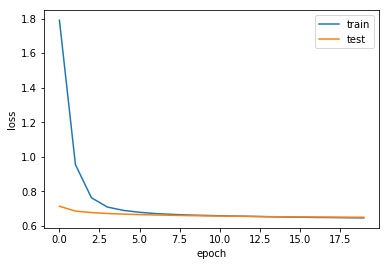

(148335, 1)
finish dataread
(None, 6, 1, 10)
(None, 6, 1, 7)
(None, 6, 1, 17)
g_MLP
drop_out
compile model success
13
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=1218 MiB, count=155, average=8046 KiB
(739080, 36, 6)
(739080, 6, 36, 1)
[Training model......]
Train on 542130 samples, validate on 194790 samples
Epoch 1/20
542130/542130 [==============================] - 11s 20us/step - loss: 1.1562 - acc: 0.5073 - val_loss: 0.6942 - val_acc: 0.5770
Epoch 2/20
542130/542130 [==============================] - 5s 9us/step - loss: 0.8097 - acc: 0.5144 - val_loss: 0.6745 - val_acc: 0.5860
Epoch 3/20
542130/542130 [==============================] - 5s 9us/step - loss: 0.7300 - acc: 0.5280 - val_loss: 0.6697 - val_acc: 0.5812
Epoch 4/20
542130/542130 [==============================] - 5s 8us/step - loss: 0.7006 - acc: 0.5426 - val_loss: 0.6651 - val_acc: 0.5997
Epoch 5/20
542130/542130 [==============================] - 5s 8us/step - loss: 0.6849 - acc: 0.5591 -

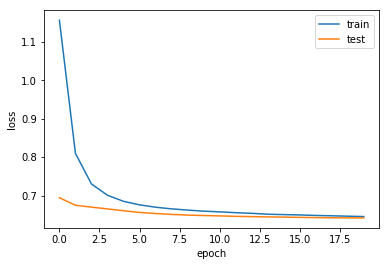

(148335, 1)
finish dataread
(None, 6, 1, 10)
(None, 6, 1, 7)
(None, 6, 1, 17)
g_MLP
drop_out
compile model success
14
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=1247 MiB, count=157, average=8136 KiB
(756900, 36, 6)
(756900, 6, 36, 1)
[Training model......]
Train on 566820 samples, validate on 187920 samples
Epoch 1/20
566820/566820 [==============================] - 12s 20us/step - loss: 1.3703 - acc: 0.5120 - val_loss: 0.7022 - val_acc: 0.5381
Epoch 2/20
566820/566820 [==============================] - 5s 9us/step - loss: 0.8287 - acc: 0.5214 - val_loss: 0.6896 - val_acc: 0.5326
Epoch 3/20
566820/566820 [==============================] - 5s 9us/step - loss: 0.7318 - acc: 0.5338 - val_loss: 0.6821 - val_acc: 0.5477
Epoch 4/20
566820/566820 [==============================] - 5s 9us/step - loss: 0.7015 - acc: 0.5426 - val_loss: 0.6773 - val_acc: 0.5627
Epoch 5/20
566820/566820 [==============================] - 5s 9us/step - loss: 0.6867 - acc: 0.5521 -

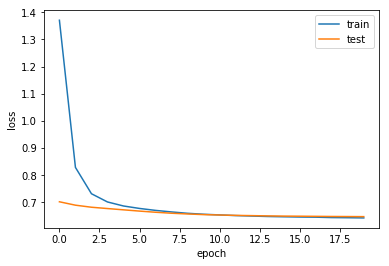

(148335, 1)
finish dataread
(None, 6, 1, 10)
(None, 6, 1, 7)
(None, 6, 1, 17)
g_MLP
drop_out
compile model success
15
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=1219 MiB, count=158, average=7902 KiB
(739830, 36, 6)
(739830, 6, 36, 1)
[Training model......]
Train on 558390 samples, validate on 179280 samples
Epoch 1/20
558390/558390 [==============================] - 12s 21us/step - loss: 1.0730 - acc: 0.5091 - val_loss: 0.7086 - val_acc: 0.4960
Epoch 2/20
558390/558390 [==============================] - 5s 9us/step - loss: 0.7629 - acc: 0.5263 - val_loss: 0.6819 - val_acc: 0.5797
Epoch 3/20
558390/558390 [==============================] - 5s 8us/step - loss: 0.7058 - acc: 0.5460 - val_loss: 0.6732 - val_acc: 0.5816
Epoch 4/20
558390/558390 [==============================] - 5s 9us/step - loss: 0.6852 - acc: 0.5599 - val_loss: 0.6646 - val_acc: 0.5833
Epoch 5/20
558390/558390 [==============================] - 5s 9us/step - loss: 0.6736 - acc: 0.5696 -

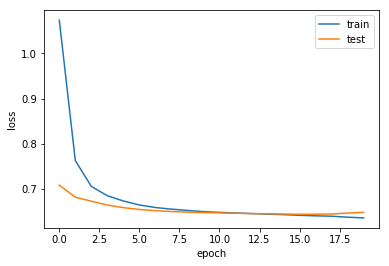

(148335, 1)
finish dataread
(None, 6, 1, 10)
(None, 6, 1, 7)
(None, 6, 1, 17)
g_MLP
drop_out
compile model success
16
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=1261 MiB, count=158, average=8171 KiB
(765030, 36, 6)
(765030, 6, 36, 1)
[Training model......]
Train on 566310 samples, validate on 196560 samples
Epoch 1/20
566310/566310 [==============================] - 12s 22us/step - loss: 1.1492 - acc: 0.5122 - val_loss: 0.6893 - val_acc: 0.5622
Epoch 2/20
566310/566310 [==============================] - 5s 9us/step - loss: 0.7890 - acc: 0.5246 - val_loss: 0.6778 - val_acc: 0.5690
Epoch 3/20
566310/566310 [==============================] - 5s 8us/step - loss: 0.7195 - acc: 0.5400 - val_loss: 0.6715 - val_acc: 0.5703
Epoch 4/20
566310/566310 [==============================] - 5s 9us/step - loss: 0.6940 - acc: 0.5521 - val_loss: 0.6667 - val_acc: 0.5712
Epoch 5/20
566310/566310 [==============================] - 5s 9us/step - loss: 0.6802 - acc: 0.5639 -

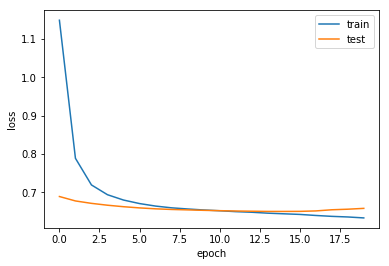

In [8]:
for z in range(head,tail,1):
    """
     V
    """
    n=daynum[tail]-daynum[head]
    df = pd.read_csv('data/JPY_data_ver2.0.csv',header=None)  # 讀取訓練數據
    print(df.shape)  
    jpy5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        jpy5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/EUR_data_ver2.0.csv',header=None)  # 讀取訓練數據
    eur5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        eur5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/CHF_data_ver2.0.csv',header=None)  # 讀取訓練數據
    chf5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        chf5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/CAD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    cad5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        cad5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/GBP_data_ver2.0.csv',header=None)  # 讀取訓練數據
    gbp5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        gbp5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/HKD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    hkd5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        hkd5months[dt] = df[0][i]  
        dt=dt+1
    print('finish dataread')
    Train_data=np.zeros(((n-l+1,len(currency),l)))
    for p in range(n-l+1):
        Train_data[p,0,:]=chf5months[p:p+l]
        Train_data[p,1,:]=cad5months[p:p+l]
        Train_data[p,2,:]=gbp5months[p:p+l]
        Train_data[p,3,:]=jpy5months[p:p+l]
        Train_data[p,4,:]=eur5months[p:p+l]
        Train_data[p,5,:]=hkd5months[p:p+l]
    MLP_unit=64
    visual_scene = Input((currencynum,l,1))
    visual_conv = ConvolutionNetworks([20,10],[(1,kn),(1,kn)])(visual_scene)
    print(K.int_shape(visual_conv))
    tag = build_tag(visual_conv)
    visual_conv = Concatenate()([tag, visual_conv])
    print(K.int_shape(visual_conv))
    
    shapes = visual_conv.shape
    w = shapes[1]
    f = shapes[2]
    features= []
    #features = np.zeros(0)
    for k1 in range(w):
        for k2 in range(f):
            def get_feature(t):
                return t[:, k1, k2, :]
            #get_feature_layer = Lambda(get_feature)
            features.append(Lambda(get_feature)(visual_conv))
    
      
    input2 = Input((14,))
    onehot_encode_question = input2
    relations = []
    concat = Concatenate()
    for feature1 in features:
        for feature2 in features:
            relations.append(concat([feature1, feature2, onehot_encode_question]))    
    
     
    g_MLP = get_MLP(4, get_dense(4,MLP_unit))
    
    print("g_MLP")
    mid_relations = []
    for r in relations:
        mid_relations.append(g_MLP(r))
    
    combined_relation = Add()(mid_relations)
    
    #f_MLP
    rn = dropout_dense(combined_relation,MLP_unit)
    rn = dropout_dense(rn,MLP_unit)
    print('drop_out')
    
    pred = Dense(1, activation = 'sigmoid')(rn)
    
    
    #model = Model(inputs=[visual_scene])
    model = Model(inputs=[visual_scene, input2, tag], outputs = pred)
    optimizer = Adam(lr = 3e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print('compile model success')    

    #model.summary()
    print(z)
    fit_show(Train_data,daynum[z],daynum[z+3],daynum[z+4])
    

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 6, 36, 1)     0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 6, 32, 20)    120         input_13[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 6, 8, 20)     0           conv2d_9[0][0]                   
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 6, 8, 20)     80          max_pooling2d_9[0][0]            
__________________________________________________________________________________________________
conv2d_10 

In [10]:
K.clear_session()

In [7]:
"""
此處開始寫rolling
"""

def fit_show(traindata,m1,m2,m3):
    
    vqa_pair = []
    for i in range(0,m3-m1-l-l,1):
        vqa_pair.append(set_question_and_answer_pair(Train_data[i],Train_data[i+l],i+l-1,all_cur_pair_P))  
        vqa_pair.append(set_HVquestion_and_HVanswer_pair(Train_data[i],Train_data[i+l],all_cur_pair_P))
        #這裡交叉塞資料才不會不小心預測未來
            
    v_tmp, q_tmp, a_tmp = [],[],[]
    for i in range(len(vqa_pair)):
        v_tmp.append(vqa_pair[i][0])
        q_tmp.append(vqa_pair[i][1])
        a_tmp.append(vqa_pair[i][2])
    v = np.array(v_tmp)
    
    # 下面這行會導致memory error
    import tracemalloc
    # Start tracing
    tracemalloc.start()
    v = np.repeat(v, len(all_cur_pair_P)*len(qtype), axis = 0)
    #這裡要注意問題的分類數量(2種:波動和漲跌)已經在前面vqa_pair變成兩倍過了
    #這裡只要考慮貨幣組合數量(P的N取2)和問的問題數量(高低同)
    snap = tracemalloc.take_snapshot()
    # Evaluate result
    stats = snap.statistics('lineno')
    for stat in stats[:1]:
        print(stat)
    
    q, a = [],[]
    for i in range(len(q_tmp)):
        for value in q_tmp[i].values():
            q.append(value)
    q = np.vstack(q)
    q = np.vstack(q)
    
    for i in range(len(a_tmp)):
        for value in a_tmp[i].values():
            a.append(value)
    a = np.vstack(a)
    a = a.reshape(a.shape[0]*a.shape[1])
    v=np.swapaxes(v,1,2)
    print(v.shape)
    v = v.reshape(len(v),currencynum,l,1)
    print(v.shape)
    print("[Training model......]")
    
    #Train_v=v[:]
    
    Train_v=v[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]# -1-72+1=-72
    Train_q=q[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Train_a=a[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Test_v=v[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_q=q[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_a=a[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    history = model.fit([Train_v, Train_q], Train_a,validation_data=([Test_v,Test_q],Test_a),batch_size=batch_size ,epochs = epochs,shuffle=False)
    pred = model.predict([Test_v, Test_q])
    count = 0
    print(pred)
    for i in range(pred.shape[0]):
        if pred[i] <= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
            
        if pred[i] == Test_a[i]:
            count+=1
    print(count,count/pred.shape[0])
    """
    分開兩種問題的test集
    """
    flag=0
    v_trend=[]
    q_trend=[]
    a_trend=[]
    v_vol=[]
    q_vol=[]
    a_vol=[]
    trend_count=0
    vol_count=0
    for ii in range(0,len(Test_q)):
        if(flag==0):
            #print(0)
            v_trend.append(Test_v[ii])
            q_trend.append(Test_q[ii])
            a_trend.append(Test_a[ii])
            trend_count=trend_count+1
            if(trend_count==90):
                trend_count=0
                flag=1
        elif(flag==1):
            #print(1)
            v_vol.append(Test_v[ii])
            q_vol.append(Test_q[ii])
            a_vol.append(Test_a[ii])
            vol_count=vol_count+1
            if(vol_count==90):
                vol_count=0
                flag=0
    
    """
    分開兩種問題的predict正確率
    """
    pred_trend = model.predict([v_trend, q_trend])
    count = 0
    for i in range(pred_trend.shape[0]):
        if pred_trend[i] <= 0.5:
            pred_trend[i] = 0
        else:
            pred_trend[i] = 1
            
        if pred_trend[i] == a_trend[i]:
            count+=1
    print("trend_test_acc:")
    print(count,count/pred_trend.shape[0])    
    total_test_trend.append(count/pred_trend.shape[0])

    pred_vol = model.predict([v_vol, q_vol])
    count = 0
    for i in range(pred_vol.shape[0]):
        if pred_vol[i] <= 0.5:
            pred_vol[i] = 0
        else:
            pred_vol[i] = 1
            
        if pred_vol[i] == a_vol[i]:
            count+=1
    print("vol_test_acc:")
    print(count,count/pred_vol.shape[0]) 
    total_test_vol.append(count/pred_vol.shape[0])
    
    print("Reverse section--------------------------------------------------------------------------")
    Test_q_reverse=Test_q
    temp=Test_q_reverse[:,2:8]
    Test_q_reverse[:,2:8]=Test_q_reverse[:,8:14]
    Test_q_reverse[:,8:14]=temp
    Test_a_reverse=-1*Test_a+1
    pred = model.predict([Test_v, Test_q_reverse])
    count = 0
    print(pred)

    """
    benchmark1
    """
    benchacc=0
    for i in range(Test_a.shape[0]):
        benchacc=benchacc+Test_a[i]
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("猜答案多的那邊 benchacc1:")
    print(benchacc)

    """
    benchmark2
    """
    #第一個直接猜1
    benchacc=0
    for i in range(Test_a.shape[0]-1):
        if(Test_a[i]!=Test_a[i+1]):
            benchacc=benchacc+1
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("參考前一個答案 benchacc2:")
    print(benchacc)    

    
        
def ConvolutionNetworks(fn,ks):
    def conv(model):
        for i in range(len(fn)):
            model = (Conv2D(filters=fn[i],kernel_size=ks[i],padding='valid',activation='relu'))(model)  
            model = (MaxPooling2D(pool_size=(1,pl)))(model)
            model = BatchNormalization()(model)
        return model
    return conv



def get_dense(n, MLP_unit):
    r = []
    for k in range(n):
        r.append(Dense(MLP_unit, activation='relu'))
    return r

def get_MLP(n, denses):
    def g(x):
        d = x
        for k in range(n):
            d = denses[k](d)
        return d
    return g

def dropout_dense(x,MLP_unit):
    y = Dense(MLP_unit)(x)
    y = Dropout(0.5)(y)
    y = Activation('relu')(y)
    return y


def build_tag(conv):
    d = K.int_shape(conv)[1]
    d2 = K.int_shape(conv)[2]
    tag = np.zeros((d,d2,d+1))
    for i in range(d):
        for j in range(d2):
            tag[i,j,d] = float(int(i%d))/(d-1)*2-1
            tag[i,j,i] = 1
    tag = K.variable(tag)
    tag = K.expand_dims(tag,axis=0)
    batch_size = K.shape(conv)[0]
    tag = K.tile(tag,[batch_size,1,1,1])
    print(K.int_shape(tag))
    return Input(tensor=tag)
    plt.show()    
def ConvolutionNetworks(fn,ks):
    def conv(model):
        for i in range(len(fn)):
            model = (Conv2D(filters=fn[i],kernel_size=ks[i],padding='valid',activation='relu'))(model)  
            model = (MaxPooling2D(pool_size=(1,pl)))(model)
            model = BatchNormalization()(model)
        return model
    return conv



def get_dense(n, MLP_unit):
    r = []
    for k in range(n):
        r.append(Dense(MLP_unit, activation='relu'))
    return r

def get_MLP(n, denses):
    def g(x):
        d = x
        for k in range(n):
            d = denses[k](d)
        return d
    return g

def dropout_dense(x,MLP_unit):
    y = Dense(MLP_unit)(x)
    y = Dropout(0.5)(y)
    y = Activation('relu')(y)
    return y


def build_tag(conv):
    d = K.int_shape(conv)[1]
    d2 = K.int_shape(conv)[2]
    tag = np.zeros((d,d2,d+1))
    for i in range(d):
        for j in range(d2):
            tag[i,j,d] = float(int(i%d))/(d-1)*2-1
            tag[i,j,i] = 1
    tag = K.variable(tag)
    tag = K.expand_dims(tag,axis=0)
    batch_size = K.shape(conv)[0]
    tag = K.tile(tag,[batch_size,1,1,1])
    print(K.int_shape(tag))
    return Input(tensor=tag)

In [8]:
for z in range(head,tail,1):
    """
     V
    """
    n=daynum[tail]-daynum[head]
    df = pd.read_csv('data/JPY_data_ver2.0.csv',header=None)  # 讀取訓練數據
    print(df.shape)  
    jpy5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        jpy5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/EUR_data_ver2.0.csv',header=None)  # 讀取訓練數據
    eur5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        eur5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/CHF_data_ver2.0.csv',header=None)  # 讀取訓練數據
    chf5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        chf5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/CAD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    cad5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        cad5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/GBP_data_ver2.0.csv',header=None)  # 讀取訓練數據
    gbp5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        gbp5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/HKD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    hkd5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        hkd5months[dt] = df[0][i]  
        dt=dt+1
    print('finish dataread')
    Train_data=np.zeros(((n-l+1,len(currency),l)))
    for p in range(n-l+1):
        Train_data[p,0,:]=chf5months[p:p+l]
        Train_data[p,1,:]=cad5months[p:p+l]
        Train_data[p,2,:]=gbp5months[p:p+l]
        Train_data[p,3,:]=jpy5months[p:p+l]
        Train_data[p,4,:]=eur5months[p:p+l]
        Train_data[p,5,:]=hkd5months[p:p+l]
    MLP_unit=64
    visual_scene = Input((currencynum,l,1))
    visual_conv = ConvolutionNetworks([20,10],[(1,kn),(1,kn)])(visual_scene)
    print(K.int_shape(visual_conv))
    tag = build_tag(visual_conv)
    visual_conv = Concatenate()([tag, visual_conv])
    print(K.int_shape(visual_conv))
    
    shapes = visual_conv.shape
    w = shapes[1]
    f = shapes[2]
    features= []
    #features = np.zeros(0)
    for k1 in range(w):
        for k2 in range(f):
            def get_feature(t):
                return t[:, k1, k2, :]
            #get_feature_layer = Lambda(get_feature)
            features.append(Lambda(get_feature)(visual_conv))
    
      
    input2 = Input((14,))
    onehot_encode_question = input2
    relations = []
    concat = Concatenate()
    for feature1 in features:
        for feature2 in features:
            relations.append(concat([feature1, feature2, onehot_encode_question]))    
    
     
    g_MLP = get_MLP(4, get_dense(4,MLP_unit))
    
    print("g_MLP")
    mid_relations = []
    for r in relations:
        mid_relations.append(g_MLP(r))
    
    combined_relation = Add()(mid_relations)
    
    #f_MLP
    rn = dropout_dense(combined_relation,MLP_unit)
    rn = dropout_dense(rn,MLP_unit)
    print('drop_out')
    
    pred = Dense(1, activation = 'sigmoid')(rn)
    
    
    #model = Model(inputs=[visual_scene])
    model = Model(inputs=[visual_scene, input2, tag], outputs = pred)
    optimizer = Adam(lr = 3e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print('compile model success')    

    #model.summary()
    print(z)
    fit_show(Train_data,daynum[z],daynum[z+3],daynum[z+4])
    

(148335, 1)
finish dataread
(None, 6, 1, 10)
(None, 6, 1, 7)
(None, 6, 1, 17)
g_MLP
drop_out
compile model success
9
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=1215 MiB, count=2, average=607 MiB
(737100, 36, 6)
(737100, 6, 36, 1)
[Training model......]
Train on 549540 samples, validate on 185400 samples
Epoch 1/45
549540/549540 [==============================] - 10s 19us/step - loss: 1.1938 - acc: 0.5123 - val_loss: 0.7159 - val_acc: 0.5257
Epoch 2/45
549540/549540 [==============================] - 5s 9us/step - loss: 0.8004 - acc: 0.5110 - val_loss: 0.6938 - val_acc: 0.5411
Epoch 3/45
549540/549540 [==============================] - 5s 9us/step - loss: 0.7241 - acc: 0.5212 - val_loss: 0.6855 - val_acc: 0.5592
Epoch 4/45
549540/549540 [==============================] - 5s 9us/step - loss: 0.6997 - acc: 0.5348 - val_loss: 0.6793 - val_acc: 0.5682
Epoch 5/45
549540/549540 [==============================] - 5s 8us/step - loss: 0.6878 - acc: 0.5478 - val

Epoch 7/45
560460/560460 [==============================] - 5s 9us/step - loss: 0.6837 - acc: 0.5610 - val_loss: 0.6602 - val_acc: 0.6084
Epoch 8/45
560460/560460 [==============================] - 5s 8us/step - loss: 0.6796 - acc: 0.5658 - val_loss: 0.6589 - val_acc: 0.6108
Epoch 9/45
560460/560460 [==============================] - 5s 8us/step - loss: 0.6763 - acc: 0.5689 - val_loss: 0.6574 - val_acc: 0.6109
Epoch 10/45
560460/560460 [==============================] - 5s 9us/step - loss: 0.6731 - acc: 0.5731 - val_loss: 0.6557 - val_acc: 0.6117
Epoch 11/45
560460/560460 [==============================] - 5s 8us/step - loss: 0.6703 - acc: 0.5773 - val_loss: 0.6544 - val_acc: 0.6122
Epoch 12/45
560460/560460 [==============================] - 5s 8us/step - loss: 0.6683 - acc: 0.5800 - val_loss: 0.6525 - val_acc: 0.6129
Epoch 13/45
560460/560460 [==============================] - 5s 8us/step - loss: 0.6658 - acc: 0.5836 - val_loss: 0.6511 - val_acc: 0.6129
Epoch 14/45
560460/560460 [===

547620/547620 [==============================] - 5s 9us/step - loss: 0.6545 - acc: 0.5942 - val_loss: 0.6422 - val_acc: 0.6074
Epoch 16/45
547620/547620 [==============================] - 5s 9us/step - loss: 0.6529 - acc: 0.5969 - val_loss: 0.6414 - val_acc: 0.6079
Epoch 17/45
547620/547620 [==============================] - 5s 9us/step - loss: 0.6527 - acc: 0.5968 - val_loss: 0.6406 - val_acc: 0.6081
Epoch 18/45
547620/547620 [==============================] - 5s 9us/step - loss: 0.6517 - acc: 0.5979 - val_loss: 0.6396 - val_acc: 0.6080
Epoch 19/45
547620/547620 [==============================] - 5s 9us/step - loss: 0.6501 - acc: 0.5993 - val_loss: 0.6389 - val_acc: 0.6083
Epoch 20/45
547620/547620 [==============================] - 5s 9us/step - loss: 0.6496 - acc: 0.5998 - val_loss: 0.6386 - val_acc: 0.6083
Epoch 21/45
547620/547620 [==============================] - 5s 9us/step - loss: 0.6489 - acc: 0.6016 - val_loss: 0.6382 - val_acc: 0.6084
Epoch 22/45
547620/547620 [============

556170/556170 [==============================] - 5s 8us/step - loss: 0.6502 - acc: 0.5960 - val_loss: 0.6408 - val_acc: 0.6145
Epoch 24/45
556170/556170 [==============================] - 5s 8us/step - loss: 0.6496 - acc: 0.5965 - val_loss: 0.6403 - val_acc: 0.6051
Epoch 25/45
556170/556170 [==============================] - 5s 8us/step - loss: 0.6491 - acc: 0.5980 - val_loss: 0.6400 - val_acc: 0.6149
Epoch 26/45
556170/556170 [==============================] - 5s 8us/step - loss: 0.6489 - acc: 0.5973 - val_loss: 0.6399 - val_acc: 0.6053
Epoch 27/45
556170/556170 [==============================] - 5s 9us/step - loss: 0.6482 - acc: 0.5983 - val_loss: 0.6397 - val_acc: 0.6149
Epoch 28/45
556170/556170 [==============================] - 5s 9us/step - loss: 0.6478 - acc: 0.5998 - val_loss: 0.6393 - val_acc: 0.6150
Epoch 29/45
556170/556170 [==============================] - 5s 9us/step - loss: 0.6474 - acc: 0.5997 - val_loss: 0.6391 - val_acc: 0.6151
Epoch 30/45
556170/556170 [============

542130/542130 [==============================] - 5s 9us/step - loss: 0.6455 - acc: 0.6045 - val_loss: 0.6376 - val_acc: 0.6063
Epoch 32/45
542130/542130 [==============================] - 5s 9us/step - loss: 0.6447 - acc: 0.6043 - val_loss: 0.6377 - val_acc: 0.6063
Epoch 33/45
542130/542130 [==============================] - 5s 9us/step - loss: 0.6444 - acc: 0.6044 - val_loss: 0.6375 - val_acc: 0.6060
Epoch 34/45
542130/542130 [==============================] - 5s 9us/step - loss: 0.6437 - acc: 0.6053 - val_loss: 0.6375 - val_acc: 0.6055
Epoch 35/45
542130/542130 [==============================] - 5s 9us/step - loss: 0.6430 - acc: 0.6062 - val_loss: 0.6376 - val_acc: 0.6056
Epoch 36/45
542130/542130 [==============================] - 5s 9us/step - loss: 0.6427 - acc: 0.6057 - val_loss: 0.6379 - val_acc: 0.6050
Epoch 37/45
542130/542130 [==============================] - 5s 9us/step - loss: 0.6419 - acc: 0.6062 - val_loss: 0.6379 - val_acc: 0.6053
Epoch 38/45
542130/542130 [============

566820/566820 [==============================] - 5s 9us/step - loss: 0.6406 - acc: 0.6063 - val_loss: 0.6361 - val_acc: 0.6097
Epoch 40/45
566820/566820 [==============================] - 5s 9us/step - loss: 0.6402 - acc: 0.6055 - val_loss: 0.6369 - val_acc: 0.6083
Epoch 41/45
566820/566820 [==============================] - 5s 9us/step - loss: 0.6400 - acc: 0.6075 - val_loss: 0.6361 - val_acc: 0.6100
Epoch 42/45
566820/566820 [==============================] - 5s 9us/step - loss: 0.6396 - acc: 0.6073 - val_loss: 0.6363 - val_acc: 0.6110
Epoch 43/45
566820/566820 [==============================] - 5s 9us/step - loss: 0.6393 - acc: 0.6074 - val_loss: 0.6367 - val_acc: 0.6095
Epoch 44/45
566820/566820 [==============================] - 5s 9us/step - loss: 0.6388 - acc: 0.6073 - val_loss: 0.6372 - val_acc: 0.6102
Epoch 45/45
566820/566820 [==============================] - 5s 9us/step - loss: 0.6384 - acc: 0.6072 - val_loss: 0.6382 - val_acc: 0.6098
[[0.5003475 ]
 [0.5029592 ]
 [0.4883614

[[0.48554412]
 [0.4810999 ]
 [0.47849414]
 ...
 [0.52169937]
 [0.59496444]
 [0.59496444]]
猜答案多的那邊 benchacc1:
0.5392124051762606
參考前一個答案 benchacc2:
0.615863453815261
(148335, 1)
finish dataread
(None, 6, 1, 10)
(None, 6, 1, 7)
(None, 6, 1, 17)
g_MLP
drop_out
compile model success
16
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=1261 MiB, count=158, average=8171 KiB
(765030, 36, 6)
(765030, 6, 36, 1)
[Training model......]
Train on 566310 samples, validate on 196560 samples
Epoch 1/45
566310/566310 [==============================] - 14s 24us/step - loss: 1.4668 - acc: 0.5244 - val_loss: 0.7196 - val_acc: 0.5337
Epoch 2/45
566310/566310 [==============================] - 5s 9us/step - loss: 0.8534 - acc: 0.5260 - val_loss: 0.6783 - val_acc: 0.5922
Epoch 3/45
566310/566310 [==============================] - 5s 9us/step - loss: 0.7457 - acc: 0.5338 - val_loss: 0.6706 - val_acc: 0.6162
Epoch 4/45
566310/566310 [==============================] - 5s 9us/step - l

568080/568080 [==============================] - 5s 9us/step - loss: 0.6997 - acc: 0.5387 - val_loss: 0.6695 - val_acc: 0.5947
Epoch 6/45
568080/568080 [==============================] - 5s 9us/step - loss: 0.6884 - acc: 0.5510 - val_loss: 0.6641 - val_acc: 0.5958
Epoch 7/45
568080/568080 [==============================] - 5s 9us/step - loss: 0.6808 - acc: 0.5595 - val_loss: 0.6587 - val_acc: 0.6017
Epoch 8/45
568080/568080 [==============================] - 5s 9us/step - loss: 0.6736 - acc: 0.5677 - val_loss: 0.6541 - val_acc: 0.6041
Epoch 9/45
568080/568080 [==============================] - 5s 9us/step - loss: 0.6684 - acc: 0.5742 - val_loss: 0.6507 - val_acc: 0.6181
Epoch 10/45
568080/568080 [==============================] - 5s 9us/step - loss: 0.6650 - acc: 0.5782 - val_loss: 0.6479 - val_acc: 0.6135
Epoch 11/45
568080/568080 [==============================] - 5s 9us/step - loss: 0.6614 - acc: 0.5825 - val_loss: 0.6459 - val_acc: 0.6172
Epoch 12/45
568080/568080 [================

561210/561210 [==============================] - 5s 9us/step - loss: 0.6551 - acc: 0.5907 - val_loss: 0.6403 - val_acc: 0.6059
Epoch 14/45
561210/561210 [==============================] - 5s 9us/step - loss: 0.6538 - acc: 0.5926 - val_loss: 0.6395 - val_acc: 0.6067
Epoch 15/45
561210/561210 [==============================] - 5s 8us/step - loss: 0.6522 - acc: 0.5945 - val_loss: 0.6388 - val_acc: 0.6074
Epoch 16/45
561210/561210 [==============================] - 5s 9us/step - loss: 0.6519 - acc: 0.5943 - val_loss: 0.6383 - val_acc: 0.6074
Epoch 17/45
561210/561210 [==============================] - 5s 9us/step - loss: 0.6506 - acc: 0.5962 - val_loss: 0.6377 - val_acc: 0.6074
Epoch 18/45
561210/561210 [==============================] - 5s 9us/step - loss: 0.6501 - acc: 0.5964 - val_loss: 0.6373 - val_acc: 0.6079
Epoch 19/45
561210/561210 [==============================] - 5s 9us/step - loss: 0.6493 - acc: 0.5980 - val_loss: 0.6369 - val_acc: 0.6082
Epoch 20/45
561210/561210 [============

568050/568050 [==============================] - 5s 9us/step - loss: 0.6479 - acc: 0.6000 - val_loss: 0.6362 - val_acc: 0.6116
Epoch 22/45
568050/568050 [==============================] - 5s 9us/step - loss: 0.6471 - acc: 0.6016 - val_loss: 0.6353 - val_acc: 0.6119
Epoch 23/45
568050/568050 [==============================] - 5s 9us/step - loss: 0.6463 - acc: 0.6015 - val_loss: 0.6347 - val_acc: 0.6124
Epoch 24/45
568050/568050 [==============================] - 5s 8us/step - loss: 0.6460 - acc: 0.6020 - val_loss: 0.6348 - val_acc: 0.6129
Epoch 25/45
568050/568050 [==============================] - 5s 9us/step - loss: 0.6457 - acc: 0.6016 - val_loss: 0.6343 - val_acc: 0.6126
Epoch 26/45
568050/568050 [==============================] - 5s 9us/step - loss: 0.6453 - acc: 0.6028 - val_loss: 0.6335 - val_acc: 0.6128
Epoch 27/45
568050/568050 [==============================] - 5s 9us/step - loss: 0.6451 - acc: 0.6021 - val_loss: 0.6334 - val_acc: 0.6130
Epoch 28/45
568050/568050 [============

558870/558870 [==============================] - 5s 9us/step - loss: 0.6460 - acc: 0.6009 - val_loss: 0.6337 - val_acc: 0.6098
Epoch 30/45
558870/558870 [==============================] - 5s 9us/step - loss: 0.6459 - acc: 0.6013 - val_loss: 0.6335 - val_acc: 0.6101
Epoch 31/45
558870/558870 [==============================] - 5s 8us/step - loss: 0.6454 - acc: 0.6032 - val_loss: 0.6333 - val_acc: 0.6102
Epoch 32/45
558870/558870 [==============================] - 5s 9us/step - loss: 0.6448 - acc: 0.6023 - val_loss: 0.6333 - val_acc: 0.6079
Epoch 33/45
558870/558870 [==============================] - 5s 9us/step - loss: 0.6450 - acc: 0.6029 - val_loss: 0.6333 - val_acc: 0.6036
Epoch 34/45
558870/558870 [==============================] - 5s 9us/step - loss: 0.6449 - acc: 0.6028 - val_loss: 0.6333 - val_acc: 0.6064
Epoch 35/45
558870/558870 [==============================] - 5s 9us/step - loss: 0.6446 - acc: 0.6035 - val_loss: 0.6331 - val_acc: 0.6063
Epoch 36/45
558870/558870 [============